# Inference on Bayesian Network

## Load Data, Create DAG

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,native.country,income
2,5,2,2,0,0,0,3,0,0
3,1,2,0,0,0,0,0,0,0
2,0,1,1,1,0,0,3,0,0
4,0,1,0,1,4,0,3,0,0
1,0,2,0,3,4,1,3,1,0
2,0,3,0,0,0,1,3,0,0


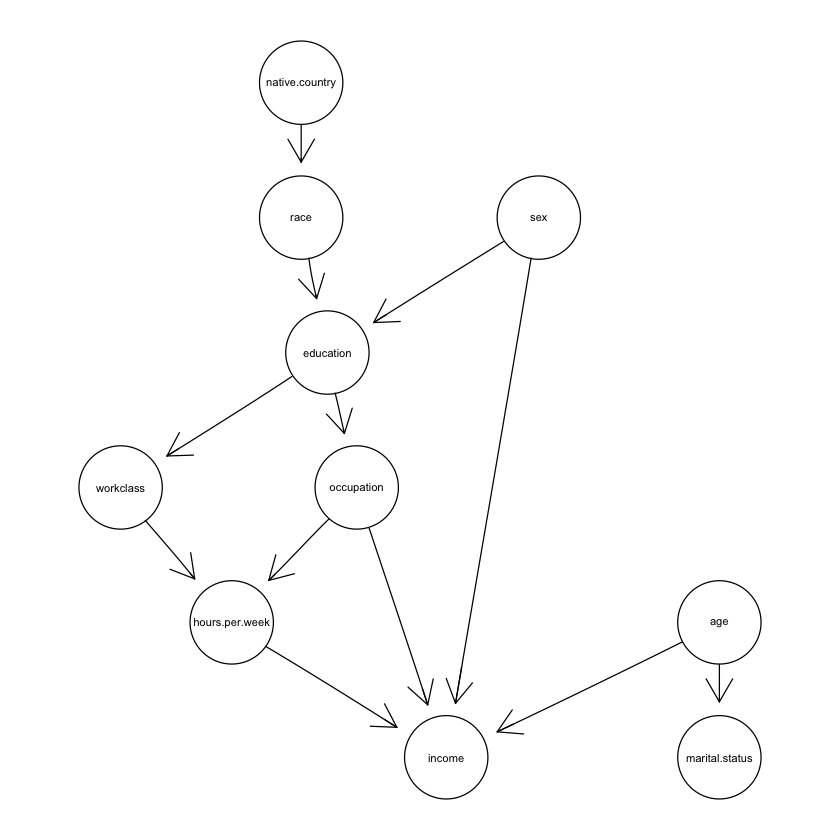

In [2]:
library("gRain")
library("Rgraphviz")
library("dagitty")
library("combinat")

options(warn=-1)
#  setwd("/Users/apple1/Dropbox/Uni/Nijmegen/WS17_18/BN")
#setwd("D:/RU/Sem1/Bayesian Networks/Project")
setwd("/Users/lisa/Documents/Uni/03.SemesterMaster/BN/bn17")
# setwd("C:/Users/Valentin/Uni/RU/Sem1/Bayesian Networks")
data <- read.table(header=T, sep=",", 'adult_cleaned.csv')


our_network <- dag(~ race:native.country + education:race:sex + workclass:education + hours.per.week:workclass:occupation + occupation:education + marital.status:age + income:age:sex:occupation:hours.per.week)
plot(our_network)
head(data)

data[data=="?"]<-NA
data<-data[complete.cases(data),]

In [3]:
g <- dagitty( "dag{ native.country -> race -> education -> occupation -> hours.per.week -> income; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; age -> income; age -> marital.status}" )
independencies <- impliedConditionalIndependencies( g )
print(independencies)
print(length(independencies))

age _||_ education
age _||_ hours.per.week
age _||_ native.country
age _||_ occupation
age _||_ race
age _||_ sex
age _||_ workclass
education _||_ hours.per.week | occupation, workclass
education _||_ income | hours.per.week, occupation, sex
education _||_ income | occupation, sex, workclass
education _||_ marital.status
education _||_ native.country | race
hours.per.week _||_ marital.status
hours.per.week _||_ native.country | race
hours.per.week _||_ native.country | education
hours.per.week _||_ native.country | occupation, workclass
hours.per.week _||_ race | education
hours.per.week _||_ race | occupation, workclass
hours.per.week _||_ sex | education
hours.per.week _||_ sex | occupation, workclass
income _||_ marital.status | age
income _||_ native.country | race
income _||_ native.country | education, sex
income _||_ native.country | occupation, sex, workclass
income _||_ native.country | hours.per.week, occupation, sex
income _||_ race | education, sex
income _||_ race | occup

## Test Independencies

In [6]:
test_network <- function(data, independencies, sig_threshold){
    num_test <- 0
    num_failed <- 0
    all <- length(data[,1])
    sig_results <- c()
    # Loop through all found independencies
    for(i in 1:length(independencies)){
        # Get variables and conditioning set
        indp <- independencies[i]
        xyz <- unlist(indp) 
        # If conditioning set is empty testing is easy
        if(length(xyz)==2){
            #Chi-square test rmsea correction to test for implied statistical independence
            tst <- chisq.test(data[,xyz[1]], data[,xyz[2]])
            res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(data) - 1)*tst$parameter),0))
            #If result is larger than 0.05 we reject the null hypothesis of the variables being independent
            if(res > sig_threshold){
                print(paste('test: ', xyz[1], ' and ', xyz[2]))
                print(res)
                num_failed <- num_failed + 1
                print('-----------------')
            }
            num_test <- num_test + 1
            sig_results <- c(sig_results,res)
        }
        # If conditioning set is not empty testing is more involved
        else{
            failed <- 0
            print(paste(c('test ', xyz[1], ' and ', xyz[2], 'given ', xyz[-(1:2)]), collapse=' '))
            # We have to test for independence given all possible value combinations
            # of the conditioning variables
            strata <- list()
            for(i in 1:length(xyz[-(1:2)])){
                    # Get values of variables sorted by frequency
                    strata[i] <- as.data.frame(sort(table(data[,xyz[2+i]]),decreasing=T))
            }
            # Get all possible combinations of values
            comb_strata = expand.grid(strata)
            visited <- 0
            idx <- 1
            l_res <- c()
            # Test conditions until 80% of data was tested
            while(visited<0.8*all){
                # Get data given conditioning set
                subdata <- data[interaction(data[,xyz[-(1:2)]]) == interaction(comb_strata[idx,]),]
                x <- subdata[,xyz[1]]
                y <- subdata[,xyz[2]]
                # Only test if enough data (unique values) is available
                if(length(unique(x)) < 2 || length(unique(y)) < 2){
                    break
                }
                tst <- chisq.test(x,y)
                res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(subdata) - 1)*tst$parameter),0))
                if(res > sig_threshold){
                    failed <- 1
                    print(paste(xyz[-(1:2)], ' = ', comb_strata[idx,]),max.levels=0)
                    print(res)

                }
                l_res <- c(l_res, res)
                visited <- visited + nrow(subdata)
                idx <- idx + 1
                num_test <- num_test + 1
            }
            if(failed){
                    num_failed <- num_failed + 1
                    print('-----------------')
            }
            if(length(l_res) > 1){
                # if several results are above threshold save the second largest for robustness
                n <- length(l_res)
                second_res <- sort(l_res,partial=n-1)[n-1]
                sig_results <- c(sig_results,second_res)
            }
            else{
                sig_results <- c(sig_results,l_res[1])
            }

        }
    }
    
    print(paste('Number of tests = ', num_test, collapse=''))
    print(paste('Number of tested independencies = ',length(independencies),collapse=''))
    print(paste('Number of failed independencies = ', num_failed, collapse=''))
    
    return(sig_results)
}




In [7]:
sig_threshold <- 0.05 
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "occupation  =  4" "workclass  =  1" 
[1] 0.06334778
[1] "-----------------"
[1] "test  education  and  income given  hours.per.week occupation sex"
[1] "hours.per.week  =  1" "occupation  =  1"     "sex  =  1"           
[1] 0.06005416
[1] "hours.per.week  =  2" "occupation  =  1"     "sex  =  1"           
[1] 0.07301177
[1] "hours.per.week  =  6" "occupation  =  1"     "sex  =  1"           
[1] 0.1842884
[1] "hours.per.week  =  1" "occupation  =  2"     "sex  =  1"           
[1] 0.1099448
[1] "hours.per.week  =  2" "occupation  =  2"     "sex  =  1"           
[1] 0.1338099
[1] "hours.per.week  =  3" "occupation  =  2"     "sex  =  1"           
[1] 0.06847684
[1] "hours.per.week  =  4" "occupation  =  2"     "sex  =  1"           
[1] 0.1269648
[1] "hours.per.week  =  5" "occupation  =  2"     "sex  =  1"           
[1] 0.09768897

#### Check rmsea-value distribution to determine cut-off
It can be seen that there is a large drop in frequency between the values 0.06 and 0.07. Therefore we set 0.07 as a significance threshold

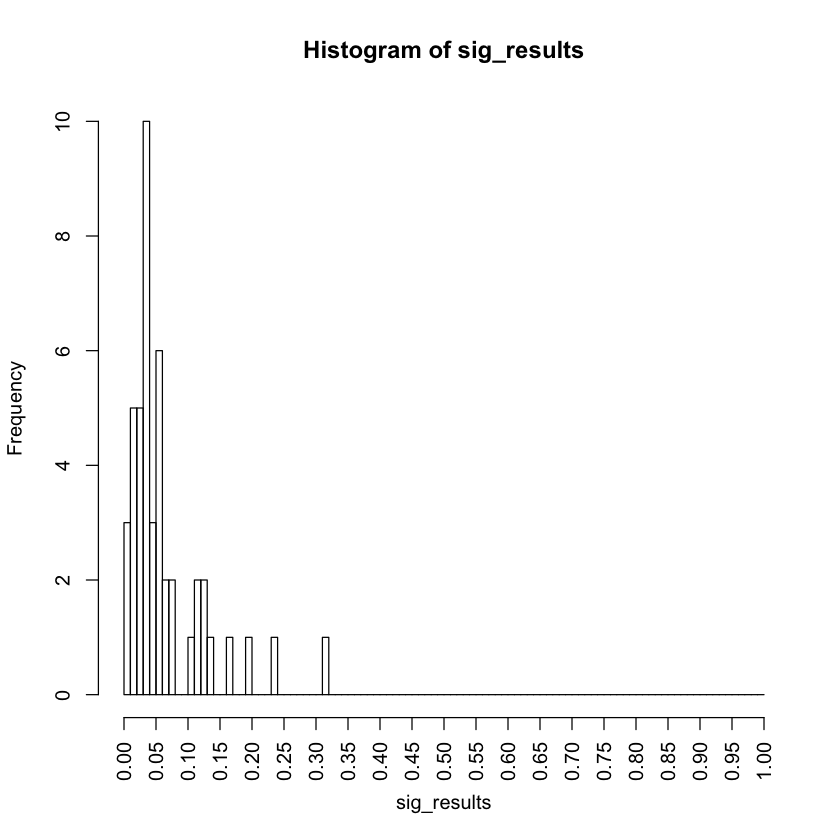

In [8]:
breaks = seq(0,1,0.01)
hist(sig_results,breaks=breaks,xlim=range(breaks),xaxt="n")
axis(1, at = seq(0, 1, by = 0.05), las=2)

In [9]:
# After examination of distribution
sig_threshold <- 0.07 
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "test  education  and  income given  hours.per.week occupation sex"
[1] "hours.per.week  =  2" "occupation  =  1"     "sex  =  1"           
[1] 0.07301177
[1] "hours.per.week  =  6" "occupation  =  1"     "sex  =  1"           
[1] 0.1842884
[1] "hours.per.week  =  1" "occupation  =  2"     "sex  =  1"           
[1] 0.1099448
[1] "hours.per.week  =  2" "occupation  =  2"     "sex  =  1"           
[1] 0.1338099
[1] "hours.per.week  =  4" "occupation  =  2"     "sex  =  1"           
[1] 0.1269648
[1] "hours.per.week  =  5" "occupation  =  2"     "sex  =  1"           
[1] 0.09768897
[1] "hours.per.week  =  6" "occupation  =  2"     "sex  =  1"           
[1] 0.171037
[1] "hours.per.week  =  1" "occupation  =  3"     "sex  =  1"           
[1] 0.1015346
[1] "hours.per.week  =  2" "occupation  =  3"     "sex  =  1"           
[1] 0.0879

In [28]:
g <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income}" )
independencies <- impliedConditionalIndependencies( g )
print(independencies)
print(length(independencies))

age _||_ education
age _||_ occupation
age _||_ race
age _||_ sex
age _||_ workclass
education _||_ hours.per.week | occupation, sex, workclass
education _||_ marital.status
hours.per.week _||_ marital.status | age
hours.per.week _||_ race | education, sex
hours.per.week _||_ race | occupation, sex, workclass
income _||_ marital.status | age
income _||_ race | education, sex
income _||_ workclass | age, education, hours.per.week, occupation, sex
marital.status _||_ occupation
marital.status _||_ race
marital.status _||_ sex
marital.status _||_ workclass
occupation _||_ race | education, sex
occupation _||_ workclass | education
race _||_ sex
race _||_ workclass | education
sex _||_ workclass | education
[1] 22


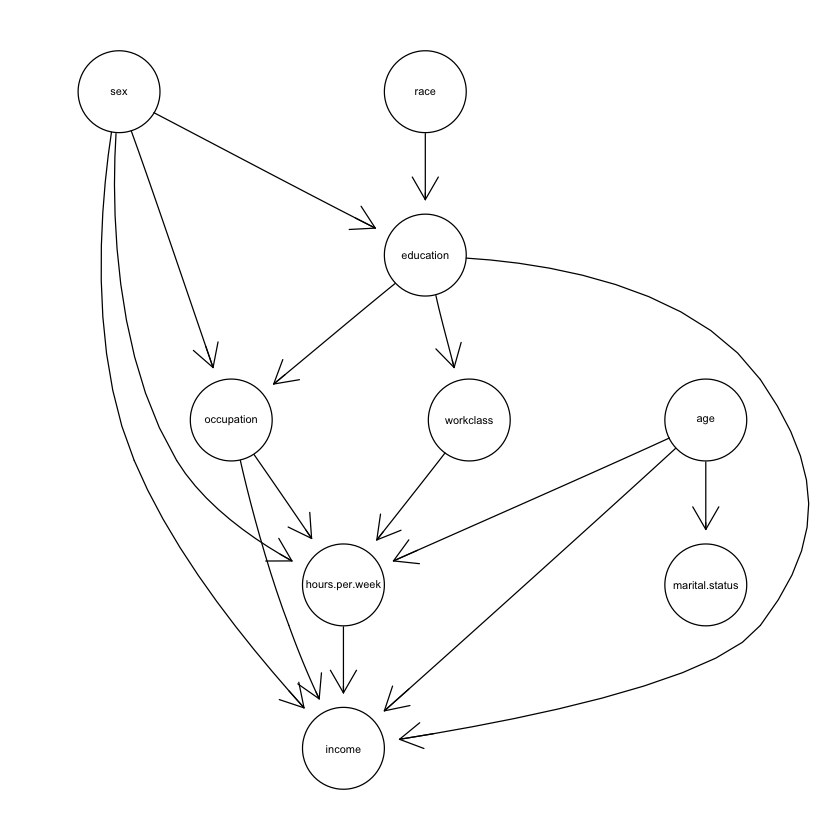

In [30]:
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education)
plot(our_network)

In [29]:
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test  education  and  hours.per.week given  occupation sex workclass"
[1] "test  hours.per.week  and  marital.status given  age"
[1] "test  hours.per.week  and  race given  education sex"
[1] "test  hours.per.week  and  race given  occupation sex workclass"
[1] "test  income  and  marital.status given  age"
[1] "age  =  2"
[1] 0.165575
[1] "age  =  1"
[1] 0.1437892
[1] "age  =  3"
[1] 0.1751547
[1] "age  =  4"
[1] 0.1650351
[1] "-----------------"
[1] "test  income  and  race given  education sex"
[1] "test  income  and  workclass given  age education hours.per.week occupation sex"
[1] "test:  marital.status  and  sex"
[1] 0.190211
[1] "-----------------"
[1] "test  occupation  and  race given  education sex"
[1] "test  occupation  and  workclass given  education"
[1] "test  race  and  workclass given  education"
[1] "test  sex  and  workclass given  education"
[1] "Number of tests =  60"
[1] "Number of tested independencies =  22"
[1] "Number of failed independencies =  2"


## Inference

In [31]:
## Load deleted rows
del_data <- read.table(header=T, sep=",", 'adult_cleaned_deleted.csv')
new_data <- read.table(header=T, sep=",", 'adult_cleaned_deleted.csv')

del_data$native.country <- NULL
new_data$native.country <- NULL
data$native.country <- NULL

In [32]:
# Create network object
net1 <- compile( grain( our_network, data, smooth=1 ) )
pp <- extractCPT( data, our_network, smooth=1)

### Marginals

In [15]:
## No evidence income
print('0: <=50k, 1: >50k')
q1 <- querygrain(net1, nodes='income',type = "marginal", evidence = NULL, exclude = TRUE, normalize = TRUE, result = "array", details = 0)
print('Inferred')
print(q1)
print('Frequencies')
t <- table(data['income'])
print(paste(t[[1]] / (t[[1]]+t[[2]]),t[[2]] / (t[[1]]+t[[2]]) , collapse=''))

[1] "0: <=50k, 1: >50k"
[1] "Inferred"
$income
income
        0         1 
0.7401223 0.2598777 

[1] "Frequencies"
[1] "0.759190442553976 0.240809557446024"


### Evidences

In [16]:
## Given White, male
net2 <- setEvidence(net1, c("sex","race"), c("0", "0"),propagate=TRUE)
q2 <- querygrain(net2, nodes='income',type = "marginal")
print(q2)

$income
income
        0         1 
0.6911596 0.3088404 



In [18]:
## Female query Education
net4 <- setEvidence(net1, c("sex"), c("1"),propagate=TRUE)
q4 <- querygrain(net4, nodes='education',type = "marginal")
print(q4)

$education
education
          0           1           2           3           4           5 
0.028324324 0.489110700 0.413002979 0.051638636 0.009222246 0.008701115 



In [19]:
## Male query Education
net5 <- setEvidence(net1, c("sex"), c("0"),propagate=TRUE)
q5 <- querygrain(net5, nodes='education',type = "marginal")
print(q5)

$education
education
         0          1          2          3          4          5 
0.04104662 0.49236433 0.37557661 0.05400751 0.02203166 0.01497328 



In [20]:
# Test (can be deleted)
net4 <- setEvidence(net1, c("sex"), c("0"), propagate=TRUE)
# q4 <- querygrain(gin1c.find, nodes=c("education","native.country","sex"),type = "conditional",result = "data.frame")
q4 <- querygrain(net4, nodes=c("income"),type='marginal')
q5 <- querygrain(net1, nodes=c("income"),type='marginal')

print(q4)
print(q5)

$income
income
        0         1 
0.6926667 0.3073333 

$income
income
        0         1 
0.7401223 0.2598777 



### Missing values

In [30]:
head(del_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,NA,2,0,NA,1,0,5,1
2,NA,0,5,NA,0,0,3,0
1,NA,2,2,NA,0,0,3,0
5,NA,1,0,NA,0,0,0,0
0,NA,1,2,NA,0,1,2,0
2,NA,1,0,NA,0,0,3,0


In [39]:
verbose <- FALSE
var_names <- c('age','workclass','education','marital.status','occupation','race','sex','hours.per.week','income')
for(i in 1:dim(del_data)[1]){
    row <- del_data[i,]
    given_names <- list()
    given_vals <- list()
    missing_names <- list()
    missing_idx <- list()
    g_idx <- 1
    m_idx <- 1
    for(j in 1:length(row)){
        if(is.na(row[[j]])){
            missing_names[[m_idx]] <- var_names[[j]]
            missing_idx[[m_idx]] <- j
            m_idx <- m_idx + 1
        } else {
            given_names[[g_idx]] <- var_names[[j]]
            given_vals[[g_idx]] <- toString(row[[j]])
            g_idx <- g_idx + 1
        }
    }
    net_ev <- setEvidence(net1, unlist(given_names, use.names=FALSE), unlist(given_vals, use.names=FALSE),propagate=TRUE)
    if(length(missing_names) > 0){
        for(j in 1:length(missing_names)){
            q <- querygrain(net_ev, nodes=missing_names[[j]],type = "marginal")
            if(verbose){
                print(q)
                print('Max at')
                print(which.max(unlist(q, use.names=FALSE)))
            }
            for(a in 1:length(given_names)){
                given_vals[[a]]
            }
            new_data[i,missing_idx[[j]]] <- which.max(unlist(q, use.names=FALSE))
        }
    }
    if(verbose){
        print('-----')        
    }
}

In [40]:
head(new_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,1,2,0,1,1,0,5,1
2,1,0,5,2,0,0,3,0
1,1,2,2,1,0,0,3,0
5,1,1,0,2,0,0,0,0
0,1,1,2,2,0,1,2,0
2,1,1,0,2,0,0,3,0


In [41]:
head(del_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,NA,2,0,NA,1,0,5,1
2,NA,0,5,NA,0,0,3,0
1,NA,2,2,NA,0,0,3,0
5,NA,1,0,NA,0,0,0,0
0,NA,1,2,NA,0,1,2,0
2,NA,1,0,NA,0,0,3,0


In [13]:
write.csv(new_data, file = "../adult_added_missing_vals.csv",row.names=FALSE)

ERROR: Error in is.data.frame(x): object 'new_data' not found


In [14]:
data1 <- read.table(header=T, sep=",", 'adult_cleaned.csv')
data2 <- read.table(header=T, sep=",", 'adult_added_missing_vals.csv')

In [16]:
data1$native.country <- NULL
total <- rbind(data1, data2) 

In [17]:
sig_results <- test_network(total, independencies, sig_threshold)

[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "test  hours.per.week  and  marital.status given  age"
[1] "test  hours.per.week  and  race given  education"
[1] "test  hours.per.week  and  race given  occupation workclass"
[1] "test  hours.per.week  and  sex given  education"
[1] "education  =  1"
[1] 0.1152275
[1] "education  =  2"
[1] 0.1158512
[1] "-----------------"
[1] "test  hours.per.week  and  sex given  occupation workclass"
[1] "occupation  =  2" "workclass  =  1" 
[1] 0.1353994
[1] "occupation  =  3" "workclass  =  1" 
[1] 0.07742536
[1] "occupation  =  4" "workclass  =  1" 
[1] 0.1182034
[1] "occupation  =  5" "workclass  =  1" 
[1] 0.1712991
[1] "-----------------"
[1] "test  income  and  marital.status given  age"
[1] "age  =  2"
[1] 0.1659319
[1] "age  =  1"
[1] 0.143006
[1] "age  =  3"
[1] 0.1736704
[1] "age  =  4"
[1] 0.1650548
[1] "-----------------"
[1] "test  income  and  race given  education sex"
[1] "test  income  and  workclass given 